# 1. Imports
#

In [1]:
from random import randint, seed

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import BaseDecisionTree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
SEED = 1337

np.random.seed(SEED)
seed(SEED)


# 2. Classes and functions
#

In [3]:
class Bagging:
    def __init__(
            self,
            dataset: pd.DataFrame,
            y_name: str,
            tree: BaseDecisionTree,
            size: int = 10
            ) -> None:

        self.trees: list[BaseDecisionTree] = []
        self.tree = tree
        self.df = dataset
        self.y_name = y_name
        self.size = size

        self._set_criterion()

        self._boostrap()

    def _set_criterion(self) -> None:
        if self.tree == DecisionTreeClassifier:
            self.criterion = "entropy"
        elif self.tree == DecisionTreeRegressor:
            self.criterion = "squared_error"
        else:
            msg = "Invalid Tree type! Available are: (DecisionTreeClassifier, "
            msg += f"DecisionTreeRegressor) but was given '{type(self.tree)}'."
            raise Exception(msg)

    def _single_boostrap(self) -> BaseDecisionTree:
        x = self.df.drop([self.y_name], axis=1)
        y = self.df[self.y_name]

        new_x = []
        new_y = []
        records: int = len(self.df)
        for _ in range(records):
            index = randint(0, records-1)

            new_x.append(x.iloc[index])
            new_y.append(y.iloc[index])

        new_x = pd.DataFrame(new_x, columns=list(x.columns))
        new_y = pd.DataFrame(new_y, columns=[self.y_name])

        new_tree = self.tree(criterion=self.criterion)
        new_tree.fit(new_x, new_y)

        return new_tree

    def _boostrap(self) -> None:
        for _ in range(self.size):
            new_tree = self._single_boostrap()
            self.trees.append(new_tree)

    def _predict_classifier(self, x) -> int:
        values = []
        for tree in self.trees:
            pred = tree.predict(x)
            values.append(pred)

        if sum(values) > len(values)/2:
            return 1
        return 0

    def _predict_regresor(self, x) -> float:
        values = []

        for tree in self.trees:
            pred = tree.predict(x).astype(float)[0]
            values.append(pred)

        return np.mean(np.array(values))

    def predict(self, x) -> float:
        if self.tree == DecisionTreeClassifier:
            return self._predict_classifier(x)
        elif self.tree == DecisionTreeRegressor:
            return self._predict_regresor(x)


# 3. Test on 'SAheart.data' dataset
#

### 3.1. Bagging test

In [4]:
df = pd.read_csv("data/SAheart.data")
df = df.sample(frac=1)  # shuffle

df = pd.get_dummies(df, columns=["famhist"])

train_size = int(len(df)*0.7)

df_train = df.iloc[:train_size, :]
df_test = df.iloc[train_size:, :]

x_train = df_train.drop(["chd"], axis=1)
y_train = df_train["chd"]

x_test = df_test.drop(["chd"], axis=1)

columns = list(x_test.columns)

y_test = df_test["chd"]

print("All df shape:", df.shape)
print("Train df shape:", df_train.shape)
print("Test df shape:", df_test.shape)


All df shape: (462, 12)
Train df shape: (323, 12)
Test df shape: (139, 12)


In [5]:
my_bagging = Bagging(df_train, "chd", DecisionTreeClassifier, 30)

good = 0
all_ = 0

for i in range(len(x_test)):
    x = x_test.iloc[i].values.reshape(1, -1)
    x = pd.DataFrame(x, columns=columns)
    y = y_test.iloc[i]

    y_pred = my_bagging.predict(x)

    if y_pred == y:
        good += 1
    all_ += 1

print("Bagging accuracy:", good/all_*100)


Bagging accuracy: 69.7841726618705


### 3.2. Single tree test

In [6]:
df = pd.read_csv("data/SAheart.data")
df = df.sample(frac=1)  # shuffle

df = pd.get_dummies(df, columns=["famhist"])

train_size = int(len(df)*0.7)

df_train = df.iloc[:train_size, :]
df_test = df.iloc[train_size:, :]

x_train = df_train.drop(["chd"], axis=1)
y_train = df_train["chd"]

columns = list(x_test.columns)

y_test = df_test["chd"]

print("All df shape:", df.shape)
print("Train df shape:", df_train.shape)
print("Test df shape:", df_test.shape)


All df shape: (462, 12)
Train df shape: (323, 12)
Test df shape: (139, 12)


In [7]:
tree = DecisionTreeClassifier(criterion="entropy")

tree.fit(x_train, y_train)

good = 0
all_ = 0

for i in range(len(df_test)):
    x = x_test.iloc[i].values.reshape(1, -1)
    x = pd.DataFrame(x, columns=columns)
    y = y_test.iloc[i]

    y_pred = my_bagging.predict(x)

    if y_pred == y:
        good += 1
    all_ += 1

print("Single tree accuracy:", good/all_*100)


Single tree accuracy: 59.71223021582733


Single tree performs much worse (about 10 percentage points) than bagging.

We will check this on different train_sizes later (section 5).


# 4. Test on 'fitness.txt' dataset
#

### 4.1. Bagging test

In [8]:
df = pd.read_csv("data/fitness.txt", sep="\\s+")
df = df.sample(frac=1)  # shuffle

train_size = int(len(df)*0.7)

df_train = df.iloc[:train_size, :]
df_test = df.iloc[train_size:, :]

print("All df shape:", df.shape)
print("Train df shape:", df_train.shape)
print("Test df shape:", df_test.shape)

x_test = df_test.drop(["Oxygen"], axis=1)

columns = list(x_test.columns)

y_test = df_test["Oxygen"]


All df shape: (31, 7)
Train df shape: (21, 7)
Test df shape: (10, 7)


In [9]:
my_bagging = Bagging(df_train, "Oxygen", DecisionTreeRegressor, 30)

mse = []

for i in range(len(x_test)):
    x = x_test.iloc[i].values.reshape(1, -1)
    x = pd.DataFrame(x, columns=columns)
    y = y_test.iloc[i]

    y_pred = my_bagging.predict(x)

    mse.append(mean_squared_error([y], [y_pred]))

print("Bagging MSE:", np.mean(np.array(mse)))


Bagging MSE: 11.0731978491111


### 4.2. Single tree test

In [10]:
tree = DecisionTreeRegressor(criterion="squared_error")

tree.fit(x_train, y_train)

mse = []

for i in range(len(df_test)):
    x = x_test.iloc[i].values.reshape(1, -1)
    x = pd.DataFrame(x, columns=columns)
    y = y_test.iloc[i]

    y_pred = my_bagging.predict(x)

    mse.append(mean_squared_error([y], [y_pred]))

print("Single tree MSE:", good/all_*100)


Single tree MSE: 59.71223021582733


As in the case of the previous dataset, where the classification was binary (here there is prediction), bagging is much better than a single tree.

In this case, about six times.

# 5. Compare different train-test splits

### 5.1. Classifier

In [11]:
train_size_acc = {
    0.5: [],
    0.6: [],
    0.7: [],
    0.8: [],
    0.9: []
}

for the_train_size in train_size_acc.keys():
    for _ in range(10):
        df = pd.read_csv("data/SAheart.data")
        df = df.sample(frac=1)  # shuffle

        df = pd.get_dummies(df, columns=["famhist"])

        train_size = int(len(df)*the_train_size)

        df_train = df.iloc[:train_size, :]
        df_test = df.iloc[train_size:, :]

        x_train = df_train.drop(["chd"], axis=1)
        y_train = df_train["chd"]

        x_test = df_test.drop(["chd"], axis=1)

        columns = list(x_test.columns)

        y_test = df_test["chd"]

        my_bagging = Bagging(df_train, "chd", DecisionTreeClassifier, 30)

        good = 0
        all_ = 0

        for i in range(len(x_test)):
            x = x_test.iloc[i].values.reshape(1, -1)
            x = pd.DataFrame(x, columns=columns)
            y = y_test.iloc[i]

            y_pred = my_bagging.predict(x)

            if y_pred == y:
                good += 1
            all_ += 1

        train_size_acc[the_train_size].append(good/all_*100)

for train_size in train_size_acc:
    train_size_acc[train_size] = np.mean(np.array(train_size_acc[train_size]))

print(train_size_acc)


{0.5: 67.74891774891775, 0.6: 66.48648648648648, 0.7: 65.89928057553956, 0.8: 68.81720430107528, 0.9: 67.4468085106383}


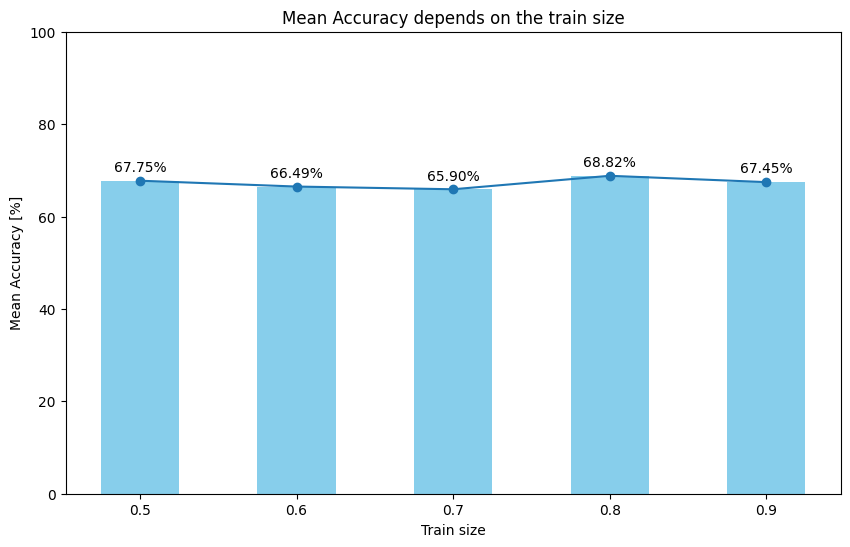

In [12]:
train_sizes = list(train_size_acc.keys())
avg_accs = list(train_size_acc.values())

plt.figure(figsize=(10, 6))
plt.ylim(0, 100)
plt.bar(train_sizes, avg_accs, color="skyblue", width=0.05)
plt.plot(train_sizes, avg_accs, marker="o")

for i, acc in enumerate(avg_accs):
    plt.text(train_sizes[i], acc + 2, f"{acc:.2f}%", ha="center")

plt.title("Mean Accuracy depends on the train size")
plt.xlabel("Train size")
plt.ylabel("Mean Accuracy [%]")

plt.show()


As we can see, changing the training size does not result in an increase in Accuracy, because we have a lot of training registrations.

We can therefore conclude that the average Accuracy value is ~67, what is still better than single tree.


### 5.2. Regressor

In [13]:
train_size_mse = {
    0.5: [],
    0.6: [],
    0.7: [],
    0.8: [],
    0.9: []
}

for the_train_size in train_size_mse.keys():
    for _ in range(10):
        df = pd.read_csv("data/fitness.txt", sep="\\s+")
        df = df.sample(frac=1)  # shuffle

        train_size = int(len(df)*the_train_size)

        df_train = df.iloc[:train_size, :]
        df_test = df.iloc[train_size:, :]

        x_test = df_test.drop(["Oxygen"], axis=1)

        columns = list(x_test.columns)

        y_test = df_test["Oxygen"]

        my_bagging = Bagging(df_train, "Oxygen", DecisionTreeRegressor, 30)

        mse = []

        for i in range(len(x_test)):
            x = x_test.iloc[i].values.reshape(1, -1)
            x = pd.DataFrame(x, columns=columns)
            y = y_test.iloc[i]

            y_pred = my_bagging.predict(x)

            mse.append(mean_squared_error([y], [y_pred]))

        train_size_mse[the_train_size].append(np.mean(np.array(mse)))

for train_size in train_size_mse:
    train_size_mse[train_size] = np.mean(np.array(train_size_mse[train_size]))

print(train_size_mse)


{0.5: 13.770896270208334, 0.6: 13.842841512905983, 0.7: 11.760289313222215, 0.8: 6.600813667825394, 0.9: 6.685324461166663}


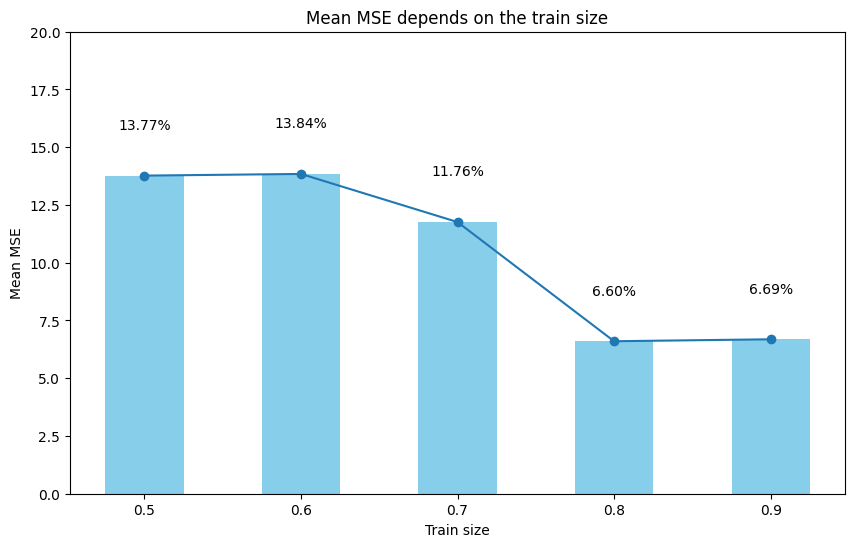

In [14]:
train_sizes = list(train_size_mse.keys())
avg_mse = list(train_size_mse.values())

plt.figure(figsize=(10, 6))
plt.ylim(0, 20)
plt.bar(train_sizes, avg_mse, color="skyblue", width=0.05)
plt.plot(train_sizes, avg_mse, marker="o")

for i, acc in enumerate(avg_mse):
    plt.text(train_sizes[i], acc + 2, f"{acc:.2f}%", ha="center")

plt.title("Mean MSE depends on the train size")
plt.xlabel("Train size")
plt.ylabel("Mean MSE")

plt.show()


In this case, increasing the training set has a large impact, but this is due to a very small data set (only a few dozen records).

# 6. Summary

After all, we can conclude that bagging clearly improves performance, even though we use the same tree implementation.

This is a good method, but it increases the computation time.